In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from kret_studies import *
from kret_studies.notebook import *
from kret_studies.complex import *

logger = get_notebook_logger()

Loaded environment variables from /Users/Akseldkw/coding/kretsinger/.env.


INFO:datasets:JAX version 0.7.2 available.


In [ ]:
from kret_studies.kret_torch import ClassificationNN

In [4]:
class MNISTClassifier(ClassificationNN):
    def set_model(self, num_classes: int) -> None:
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.cls = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),  # logits
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.model(x)  # (B, 64, 7, 7)
        logits = self.cls(h)  # (B, num_classes)
        return logits  # raw logits for CrossEntropyLoss

In [5]:
run = start_wandb_run(MNISTClassifier.name(), project="mnist")

wandb: Currently logged in as: akseldkw (akseldkw07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
KAGGLE_DIR = DATA_DIR / "kaggle"
MNIST_DIR = KAGGLE_DIR / "mnist"

In [7]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_dataset = datasets.MNIST(MNIST_DIR, download=True, train=True, transform=transform)
test_dataset = datasets.MNIST(MNIST_DIR, download=True, train=False, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
cats = torch.unique(train_dataset.targets).tolist()
num_cats = len(cats)
num_cats

10

In [9]:
model = MNISTClassifier(patience=5)

In [10]:
model.set_model(num_cats)
model.post_init()

[2025-11-14 12:27:05,148 | INFO | MNISTClassifier_v000 ] Loaded model weights and state from /Users/Akseldkw/coding/kretsinger/data/pytorch/MNISTClassifier_v000.
[2025-11-14 12:27:05,148 | INFO | MNISTClassifier_v000 ] Full State:
{'hparams': {'batchsize': 128,
             'gamma': 0.1,
             'improvement_tol': 0.0001,
             'lr': 0.001,
             'patience': 5,
             'stepsize': 7},
 'state': {'best_eval_accuracy': '99.06%',
           'best_eval_f1': '99.06%',
           'best_eval_loss': inf,
           'best_eval_r2': '-inf%',
           'epochs_trained': 2}}


In [11]:
model._log = False

In [12]:
model.train_model(train_dataloader, test_dataloader, epochs=3, batch_size=320)

100%|██████████| 3/3 [00:35<00:00, 11.84s/it]


In [14]:
pred = model.predict(test_dataloader)

In [ ]:
y_true = pred["y_true"].cpu()
y_pred = pred["y_pred"].cpu()

In [21]:
f1_score(y_true, y_pred, average="weighted")

0.9920976495762177

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [26]:
from sklearn.metrics import confusion_matrix

normalize = "true"  # or 'pred' or 'all' or None
cm = confusion_matrix(y_true, y_pred, normalize=normalize)

class_names = cats

fig, ax = uks_mpl.subplots(1, 1, 6, 6)
sns.heatmap(
    cm,
    ax=ax,
    annot=True,
    fmt=".2f" if normalize else "d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
title = "Confusion matrix" + (f" (normalize='{normalize}')" if normalize else "")
ax.set_title(title)

Text(0.5, 1.0, "Confusion matrix (normalize='true')")

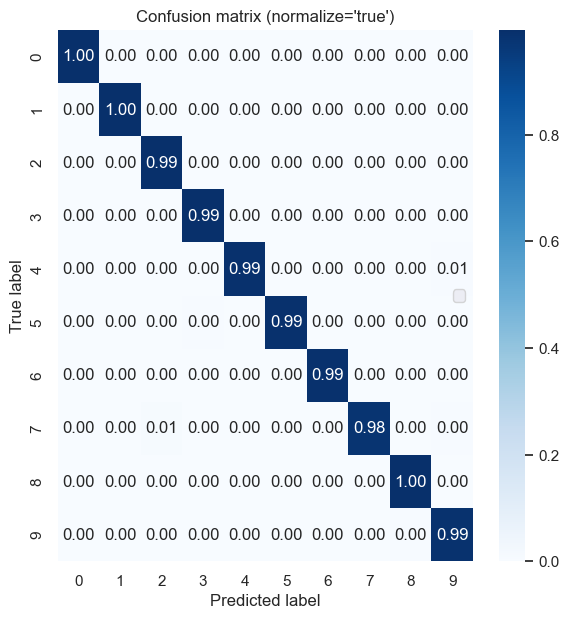

In [27]:
fig

In [28]:
# raise ValueError("STOP")
run.finish()

Eval accuracy,▁██
Eval f1,▁██
Train loss,█▄▁
Eval accuracy,0.9921
Eval f1,0.9921
Train loss,0.01993
